In [1]:
# plot and predict the slices 

import tensorflow as tf
# set TF to 1.x
tf.compat.v1.disable_v2_behavior()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import os

from sklearn.metrics import r2_score, mean_gamma_deviance, mean_tweedie_deviance#, mean_absolute_percentage_error

from utils.normalize_data import normalizeStandard, reTransformStandard, reTransformTarget

from typing import List

from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

%matplotlib inline

font = {'size'   : 16}

plt.rc('font', **font)



Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
print(tf.__version__)

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# LIMIT GPU MEMORY USAGE
gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#   except RuntimeError as e:
#     print(e)

if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1028)])
    except RuntimeError as e:
        print(e)

        
        
plt.rcParams.update({'font.size': 16})

2.3.1


In [3]:
# Specify the case you want to predict
CASE = 'UPRIME90'

# Specify the trained model you want to use
MODEL_CASE='UPRIME15'

USE_KEEP_OUT = False

# Specifiy the filter width to predict (as str 16 or 20 so far)
#FILTER_WIDTH=str(20)

path_to_test = '/home/max/HDD3_DNS/Planar/NX512/'+CASE+'/postProcess_DNN/'
path_to_models = '/home/max/Python/Data_driven_models/TF2/trained_models/all_without_cbar'

In [4]:
!ls /home/max/Python/Data_driven_models/TF2/trained_models/all_without_cbar

all_without_cbar.txt		      DNN_UPRIME5_nrns_200_blks_10_Log.h5
correlation_without_cbar.png	      prediction_without_cbar.png
DNN_UPRIME15_nrns_200_blks_10_Log.h5


In [5]:
# load a test file
if USE_KEEP_OUT:
    # keep out data with n=20
    myData_df = pd.read_parquet(join(path_to_test,'KEEP_OUT','filter_width_20_DNN_'+CASE+'_test.parquet')).sample(frac=0.3)
else:
    myData_df = pd.read_parquet(join(path_to_test,'TEST','test_'+CASE+'_1_Log.parquet')).sample(frac=0.1)


# data is already normed!!

columns = list(myData_df.columns)
print(columns)

myData_index = myData_df.index

# TODO: update FEATURES

# Features and Target
FEATURES: List[str] = [#'c_bar',
                       'c_tilde',
                       'omega_model_planar',
                       'UP_delta',
                       'SGS_flux',
                       'Delta_LES',
                       'mag_grad_c_tilde',
                       'mag_grad_U',
                       'c_prime']
    
TARGET: List[str] = ['omega_DNS_filtered']


['c_bar', 'c_tilde', 'omega_DNS_filtered', 'omega_model_planar', 'mag_grad_U', 'mag_grad_c', 'mag_grad_c_tilde', 'theta', 'phi', 'lambda_1', 'lambda_3', 'UP_delta', 'SGS_flux', 'c_prime', 'Delta_LES', 'filter_width']


In [6]:
#!ls /home/max/Python/Data_driven_models/TF2/trained_models/all_without_cbar

## Get valid indices and load the model (Log transformed!)

In [7]:
# load the model

# this is the Standard scaled model!
DNN = tf.keras.models.load_model(join(path_to_models,'DNN_'+MODEL_CASE+'_nrns_200_blks_10_Log.h5'))

# load the moments for scaling
moments = pd.read_csv(join(path_to_test, 'moments_' + CASE + '_Log.csv'), index_col=0)

DNN.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 200)          1800        Input[0][0]                      
__________________________________________________________________________________________________
res1_branch2a (Dense)           (None, 200)          40200       dense[0][0]                      
__________________________________________________________________________________________________
bn1_branch2a (BatchNormalizatio (None, 200)          800         res1_branch2a[0][0]              
_______________________________________________________________________________________

In [8]:
print(join(path_to_models,'DNN_'+MODEL_CASE+'_nrns_200_blks_10_Log.h5'))

/home/max/Python/Data_driven_models/TF2/trained_models/all_without_cbar/DNN_UPRIME15_nrns_200_blks_10_Log.h5


## Transform and scale the data, then make the prediction

In [9]:

if USE_KEEP_OUT:
    
    myData_rescaled_df = myData_df.copy()
    
    # Normalize
    myData_norm_df = normalizeStandard(myData_df.apply(np.log),moments)
            
else:
    # Normalize
    myData_norm_df = normalizeStandard(myData_df,moments)

    myData_rescaled_df = myData_df.apply(np.exp)

# use myData_norm_df for the prediction with ANNs

Text(0.5, 1.0, '$\\omega$')

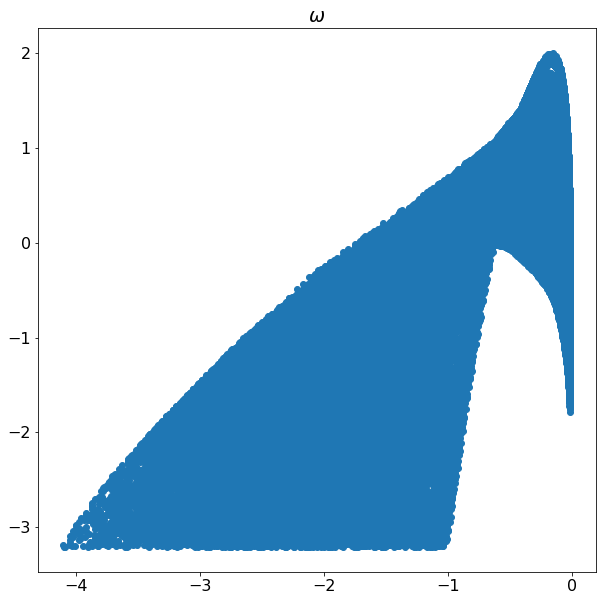

In [10]:
plt.figure(figsize=(10,10))
plt.scatter(myData_df['c_tilde'],myData_norm_df['omega_DNS_filtered'])
plt.title('$\omega$')

Text(0.5, 0, 'log($\\overline{c}$)')

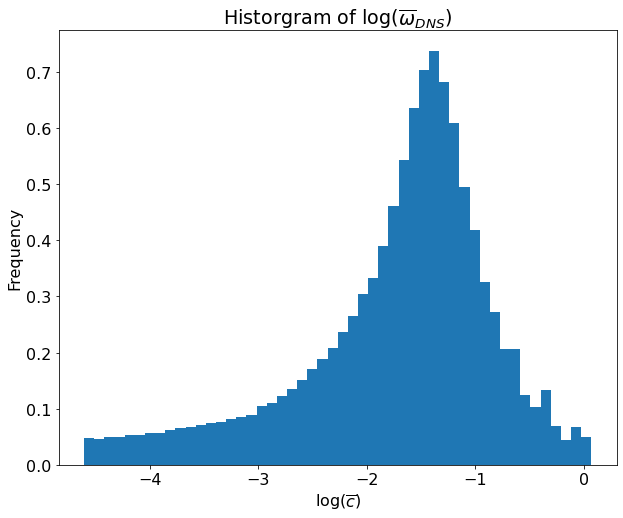

In [11]:
plt.figure(figsize=(10,8))
plt.hist(myData_df['omega_DNS_filtered'],bins=50,density=True)
plt.title('Historgram of log$(\overline{\omega}_{DNS})$')
plt.ylabel('Frequency')
plt.xlabel('log($\overline{c}$)')

Text(0.5, 0, '$\\overline{c}$')

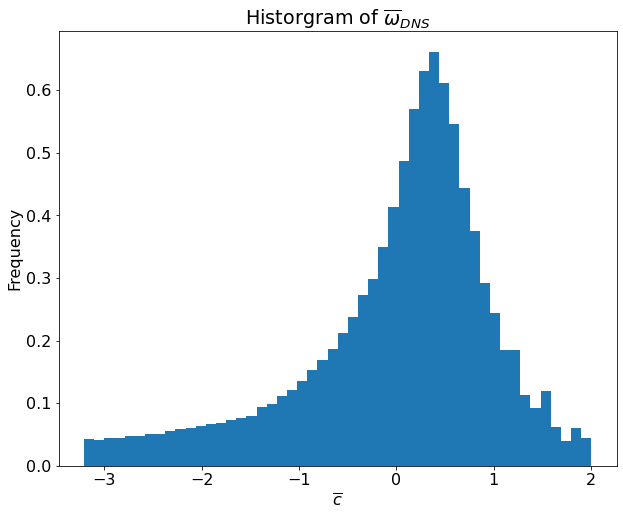

In [12]:
plt.figure(figsize=(10,8))
plt.hist(myData_norm_df['omega_DNS_filtered'],bins=50,density=True)
plt.title('Historgram of $\overline{\omega}_{DNS}$')
plt.ylabel('Frequency')
plt.xlabel('$\overline{c}$')

In [13]:
# get rid of unnecessary data
valid_index = myData_rescaled_df.loc[(myData_rescaled_df['c_tilde']<0.99) & (myData_rescaled_df['c_tilde']>0.01)].index.values

invalid_index = myData_rescaled_df.loc[(myData_rescaled_df['c_tilde']>0.99) | (myData_rescaled_df['c_tilde']<0.01)].index.values

# data frame with valid, masked 
myData_norm_df = myData_norm_df.loc[valid_index]

myData_norm_df = myData_norm_df[FEATURES+TARGET]


In [14]:
myData_norm_df.head()

,c_tilde,omega_model_planar,UP_delta,SGS_flux,Delta_LES,mag_grad_c_tilde,mag_grad_U,c_prime,omega_DNS_filtered
18545,-0.777766,0.262045,0.981303,0.401619,0.527760,-0.211137,-0.292390,1.080761,0.079981
18545,-0.196262,-0.329752,-0.603576,-0.504468,-1.525081,1.716135,1.945215,0.042346,-0.178127
292735,-0.558699,0.270032,0.352935,1.176337,0.527760,-0.095837,-0.474191,1.054521,0.115396
292735,-0.524299,0.363583,0.177236,1.054445,0.275161,0.148564,-0.201054,0.966814,0.187376
304790,0.601219,0.535202,0.213104,0.648055,-0.023600,0.424242,0.252350,0.386486,0.966476


In [15]:
################################
# make the prediction
omega_hat_norm = DNN.predict(myData_norm_df[FEATURES])
################################


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [16]:
omega_hat_rescaled = reTransformTarget(omega_hat_norm, moments)

omega_hat_predict_real = omega_hat_rescaled.apply(np.exp)

omega_DNS_filtered = myData_rescaled_df[TARGET].loc[valid_index]

## Plot the correlation between prediction and true value

Text(0, 0.5, '$\\overline{\\omega}_{ANN}$')

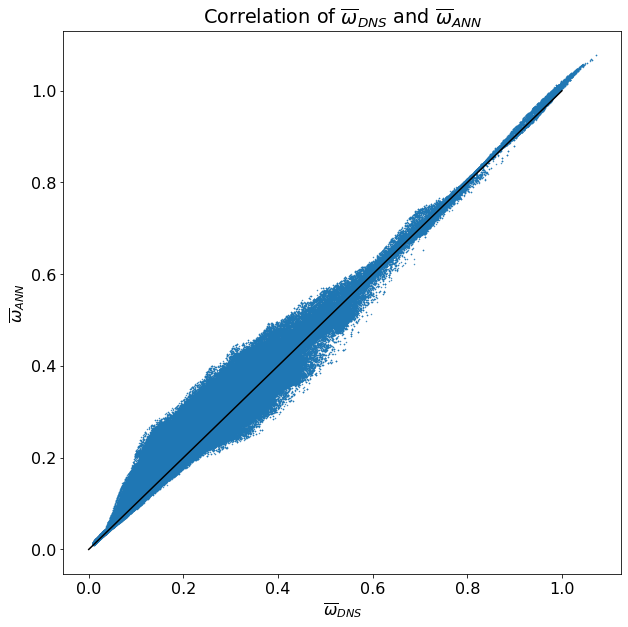

In [17]:
plt.figure(figsize=(10,10))
plt.scatter(omega_DNS_filtered,omega_hat_predict_real,s=0.2)
plt.plot([0,1],[0,1],'k')
plt.title('Correlation of $\overline{\omega}_{DNS}$ and $\overline{\omega}_{ANN}$')
plt.xlabel('$\overline{\omega}_{DNS}$')
plt.ylabel('$\overline{\omega}_{ANN}$')

### R2 score

In [18]:
import scipy
print("R2:                 ",r2_score(omega_hat_predict_real, omega_DNS_filtered))
print("tweedy deviance:    ", mean_tweedie_deviance(omega_DNS_filtered,omega_hat_predict_real))
print("mean gamma deviance:", mean_gamma_deviance(omega_DNS_filtered,omega_hat_predict_real))

R2:                  0.9596170404188286
tweedy deviance:     0.0012208235
mean gamma deviance: 0.02264514


## Compare omega vs c_tilde

(0.0, 1.0)

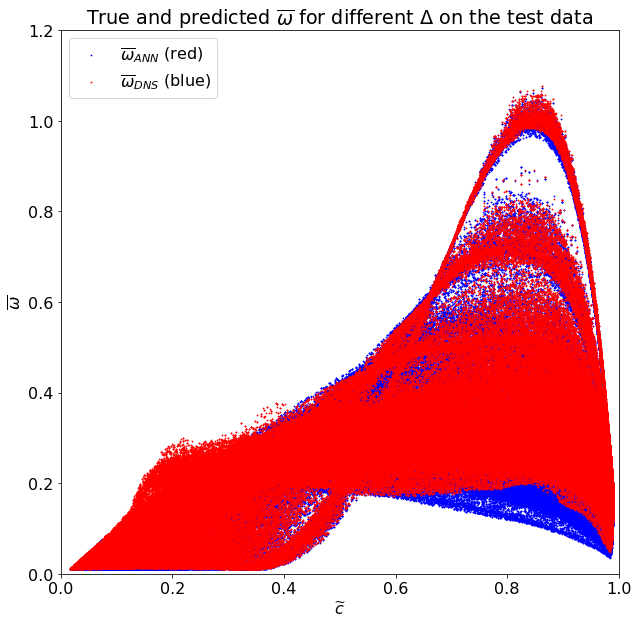

In [19]:
plt.figure(figsize=(10,10))
plt.scatter(myData_rescaled_df['c_tilde'].loc[valid_index],myData_rescaled_df[TARGET].loc[valid_index],s=0.6,c='b')
plt.scatter(myData_rescaled_df['c_tilde'].loc[valid_index],omega_hat_predict_real,c='r',s=0.6)



plt.xlabel('$\widetilde{c}$')
plt.ylabel('$\overline{\omega}$')

if USE_KEEP_OUT:
    plt.scatter(myData_rescaled_df['c_bar'].loc[valid_index],myData_rescaled_df['omega_model_planar'].loc[valid_index],s=0.6,c='k')
    plt.title('True and predicted $\overline{\omega}$ for different n=20')
    plt.ylim([0,0.6])
else:
    plt.title('True and predicted $\overline{\omega}$ for different $\Delta$ on the test data')
    plt.ylim([0,1.2])


plt.legend(['$\overline{\omega}_{ANN}$ (red)','$\overline{\omega}_{DNS}$ (blue)','$\overline{\omega}_{m}$ (black)'],loc='upper left')
    
plt.xlim([0,1])



## Now apply the SHAP method

In [ ]:
import shap
shap.initjs()

##############
# SHAP needs TF1.x
##############

In [ ]:

SHAP_test_set = myData_norm_df[FEATURES].sample(n=1000, random_state=0).to_numpy()

explainer = shap.DeepExplainer(DNN, SHAP_test_set)


In [ ]:
shap_values = explainer.shap_values(SHAP_test_set)

In [ ]:
location = 100


shap.force_plot(explainer.expected_value, shap_values[0][location,:], myData_norm_df[FEATURES].iloc[location,:])

## Feature importance

In [ ]:

shap.summary_plot(shap_values[0], myData_norm_df[FEATURES].sample(100),plot_type="bar")

In [21]:
shap_values[0].shape

(1000, 8)